# Model proto

This is a rough prototype of our RL solution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys

if '..' not in sys.path: sys.path.append('..')
from src.utils import *
from src.actions import *
from src.units import *
from src.game_utils import *
from src.agent import DnDAgent
from src.game_board import DnDBoard
from src.plot_utils import *
from src.agent_utils import get_default_action_resolver, get_states
from src.training import train_loop_trivial

## Sample agent game

In [3]:
def create_same_game(board_size=(5, 5), show_game=False, get_colormap=True):
    game = DnDBoard(board_size)

    ally = GenericSoldier("Ally soldier", attack_damage=25)
    ally2 = GenericSoldier("Ally soldier", attack_damage=25, health=50, range=4)
    #ally2 = GenericSoldier("Ally archer", health=50, attack_damage=25, speed=4, range=8)
    enemy = GenericSoldier("Enemy soldier", attack_damage=25)
    enemy2 = GenericSoldier("Enemy soldier", attack_damage=25, health=50, range=4)
    #enemy2 = GenericSoldier("Enemy archer", health=50, attack_damage=25, speed=4, range=8)
    
    place_unit_randomly(game, ally, 0)
    place_unit_randomly(game, enemy, 1)
    place_unit_randomly(game, ally2, 0)
    place_unit_randomly(game, enemy2, 1)
   
    game.initialize_game()

    if get_colormap or show_game:
        color_map = {
            ally: "Green",
            enemy: "Red",
            ally2: "Green",
            enemy2: "Red",
            #ally2: "Blue",
            #enemy2: "Purple"
        }

        if show_game: print_game(game, color_map)

        return game, color_map

    return game

In [4]:
def self_play_loop(agent, game, color_map, reset_epsilon=True, random_action_resolver=None, manual_input=False, delay=0.5):
    game_over = False
    iter_count = 0
    if reset_epsilon:
        epsilon = agent.epsilon
        agent.epsilon = 0

    print_game(game, color_map)
    try:
        while not game_over:
            try:
                iter_count += 1

                # sleeping 
                if manual_input:
                    command = input()
                    if command == 'stop':
                        raise KeyboardInterrupt()
                    elif command == 'continue':
                        manual_input = False
                else:
                    time.sleep(delay)
                
                clear_output(wait=True)
                print(f'Iteration: {iter_count}')

                _, _, new_coords, action = get_states(game, agent, random_action_resolver)
                _, game_over = take_turn(game, new_coords, action, color_map, True)
            except KeyboardInterrupt:
                print(f'\nGame interrupted after {iter_count} iterations')
                return None
    finally:
        if reset_epsilon: agent.epsilon = epsilon


    print(f'\nGame over in {iter_count} iterations. Current epsilon = {agent.epsilon}')

    return iter_count

In [6]:
# next state is delayed and can be inconsistent. Enemy reward is your punishment
def train_loop_delayed(agent: DnDAgent, game: DnDBoard, random_action_resolver=None) -> int:
    game_over = False
    iter_count = 0
    
    last_state, last_reward, last_action = None, None, None
    while not game_over:
        iter_count += 1
    
        state, action_vector, new_coords, action = get_states(game, agent, random_action_resolver)
        reward, game_over = game.take_turn(new_coords, action, skip_illegal=True)
        new_state = game.observe_board()

        ## THIS IS WRONG, FIX REWARD
        if last_state is not None:
            total_reward = last_reward - reward
            agent.memorize(last_state, last_action, total_reward, new_state, game_over)
            
        if game_over:
            agent.memorize(state, action_vector, reward, new_state, game_over)
        
        agent.learn()
        last_state = state
        last_action = action_vector
        last_reward = reward

    return iter_count

In [7]:
train_loop = train_loop_trivial

In [8]:
agent = DnDAgent(lr=0.001, board_shape=(5, 5), epsilon_delta=1e-5, epsilon_strategy='exp', in_channels=7, out_actions=2, batch_size=128, dual_learning=True, replace_model_interval=5000)
iters, eps, checkpoints = [], [], []
mag1s, mag2s = [], []

In [20]:
games = 5000
checkpoint_each = 2000
checkpoint_name = '4v4-agent'
if checkpoint_name is None: checkpoint_each = 1e99

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training') as pbar:
    for i in pbar:
        game = create_same_game(get_colormap=False)
        resolver = get_default_action_resolver(game)
        outputs = agent.predict(game.observe_board())
        metric = np.mean(np.abs(outputs), axis=(1, 2))
        iter_count = train_loop(agent, game, resolver)
        iters.append(iter_count)
        eps.append(agent.epsilon)
        pbar.set_postfix({
            'eps': agent.epsilon,
            'mag1': metric[0], 'mag2': metric[1]
        })
        mag1s.append(metric[0])
        mag2s.append(metric[1])

        iter_i = len(iters)
        if iter_i - last_checkpoint >= checkpoint_each:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            agent.save_agent(f'../checkpoints/{checkpoint_name}-{iter_i}')

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

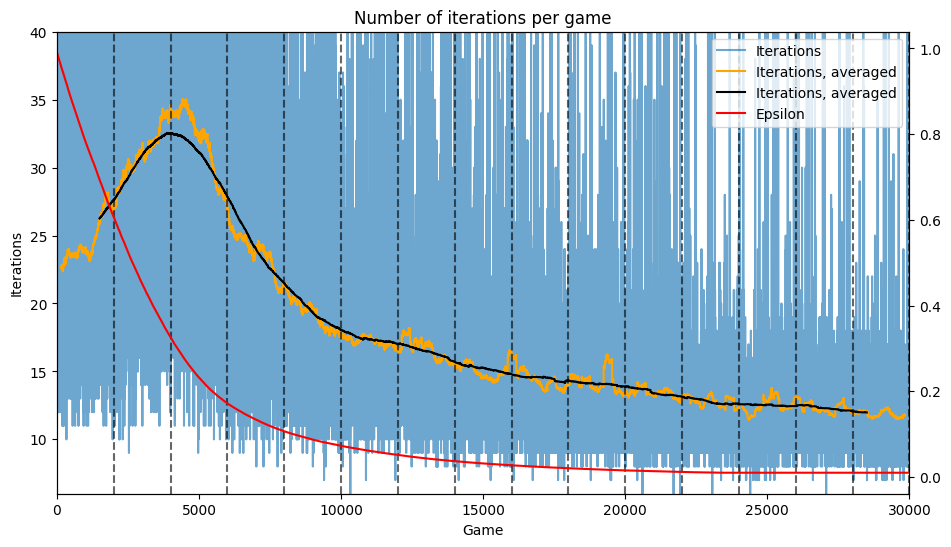

In [21]:
plot_training_history(iters, eps, checkpoints, ylim=40)

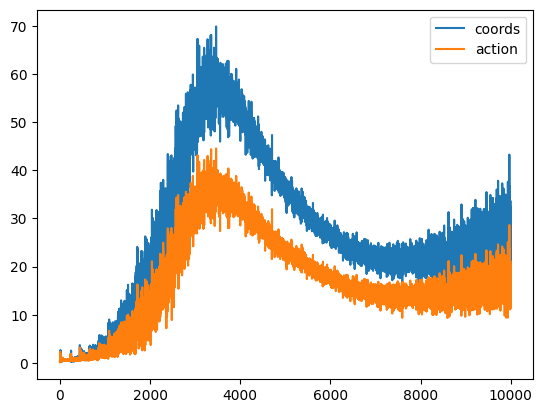

In [11]:
plt.plot(mag1s, label='coords')
plt.plot(mag2s, label='action')
# plt.yscale('log')
plt.legend()

In [12]:
game, color_map = create_same_game()

self_play_loop(agent, game, color_map, delay=0.5)
agent.epsilon = epsilon

Iteration: 17
Turn made by player #0: `Ally soldier`:
	Unit moves: (2, 3) -> (0, 4);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Ally soldier', 'target_unit': 'Enemy soldier'}

Units alive: 1
Players: 2:
	Player #0 (1 units): `Ally soldier (50 HP)`,   
	Player #1 (0 units):   
	
    0 1 2 3 4
 0         ██ 0 
 1            1 
 2            2 
 3            3 
 4            4 
    0 1 2 3 4

Next move is by player #0: `Ally soldier`

Game over in 17 iterations. Current epsilon = 0.07269349373668205


NameError: name 'epsilon' is not defined

# Visualization

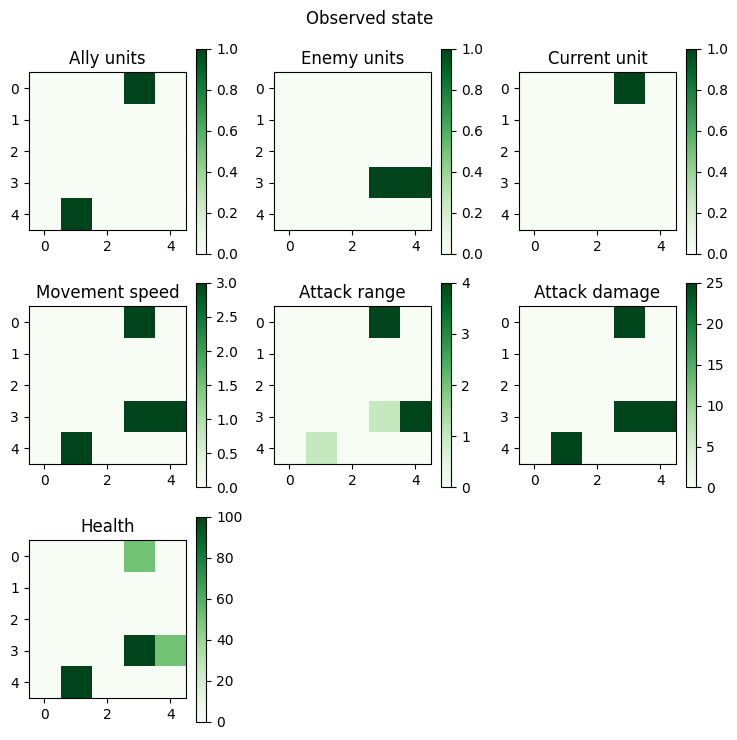

In [ ]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.get_featuremap_names(),
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

In [ ]:
game, color_map = create_same_game()
agent.game = game
print_game(game, color_map)

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally soldier (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy soldier (50 HP)`  
	
    0 1 2 3 4
 0       ██   0 
 1            1 
 2            2 
 3       ████ 3 
 4   ██       4 
    0 1 2 3 4

Next move is by player #1: `Enemy soldier`


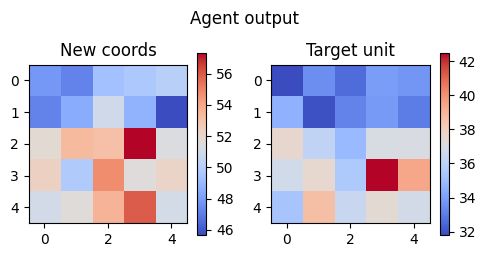

(array([2, 3], dtype=int64), array([3, 3], dtype=int64))


In [ ]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

print(agent.choose_action_vector(state))